# Exercise 6.3: Nonlinear fitting of the resonant scattering of neutron from a nucleus. 

Perform a $\chi^2$ fit of the neutron scattering data using the equations obtained through the minimization of $\chi^2$. Assume that the absolute error ($\sigma_i$) is equal for all data points and find a reasonable estimate for its magnitude. 

Use the following data:

| Energy (MeV) | Cross Section (mb)| 
| ------------ | ----------------- |
| 0 | 10.6 | 
| 25 | 16.0 | 
| 50 | 45.0 |
| 75 | 83.5 | 
| 100 | 52.8 | 
| 125 | 19.9 | 
| 150 | 10.8 | 
| 175 | 8.25 | 
| 200 | 4.7 | 

and the theoretical function $f(E) = \frac{ f_r } { (E-E_r)^2 + \Gamma^2/4 }$.

For initial guesses, look at the plot and consider that: 

At the peak, $f = a_1 / a_3$, $a_3 = \Gamma_2^2 / 4$, where $\Gamma$ is the full-width of the peak at half-maximum and $x = a_2$ is the position of the peak.

BONUS 10%: Use SciPy's ```optimize.curve_fit``` to do the fit. Compare SciPy's results to the ones you obtained. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

## Solution

Let us begin by defining the ```partiald```, ```jacobian```, and ```newton``` functions that I wrote in the previous exercise.

In [3]:
import numpy as np
from numpy import linalg
import scipy as sp

def partiald(func,a,i,h): # approximates the partial derivaitve of func wrt coordinate i at point a with step size h
    
    dx = [] # variation in the ith coordinate
    for xi in range(len(a)): # defines the increment in the function input: a vector with h in the ith coordinate and zeros everywhere else
        if xi == i:
            dx.append(h)
        else:
            dx.append(0)
    
    df = (func(np.array(a)+np.array(dx)/2)-func(np.array(a)-np.array(dx)/2)) # the increment is f(x) as a result of dx
    return df/h # the partial 

def jacobian(func,a,h): # accepts a list func of component functions and returns the Jacobian at a
    derivative = []
    for j in range(len(a)):
        row = []
        for i in range(len(a)):
            row.append(partiald(func[j],a,i,h))
        derivative.append(row)
    return derivative

def newton(func,x0,h,prec,N): # a multidimensional Newton-Raphson root finder
    """Finds a root to precision prec of a list of functions func using a multidimensional 
    Newton-Raphson method with initial guess x0. Derivatives are calculated using a central 
    difference with step size h. The function runs through N iteration of Newton-Raphson 
    searching"""
    a = x0 # sets the initial guess of the root to x0
    count = 0 # the number of root searches
    
    precCheck = []
    for i in range(len(x0)):
        precCheck.append(0) # fills a list with zeros for a check of the precision
    precGoal = []
    for i in range(len(x0)):
        precGoal.append(1) # loop ends once precCheck is filled with ones
        
    while precCheck != precGoal and count < N:
        funca = []
        for i in range(len(func)):
            funca.append(-func[i](a))
        
        dx = linalg.solve(jacobian(func,a,h),funca) # the correction to the root
        a = a + dx
        
        for i in range(len(x0)): # if the ith value of func is within prec of zero, then the ith entry of precCheck is set to 1
            if abs(func[i](a)) < prec:
                precCheck[i] = 1
                
        count = count + 1
        
    return(a,count) # returns the solution and the number of iterations

And just for fun I also define my cubic spline interpolator that I wrote for the project.

In [4]:
def spline(ins,outs): # takes in an ordered data set and returns a piecewise polynomial interpolation
    
    M = []
    aux = [0,0,2,6] # coefficients for the second derivative condition
    
    for i in range(len(ins)-1): # fills M with left endpoint continuity conditions
        row = np.zeros(4*(len(ins)-1))
        j = 0
        while j < 4:
            row[j+4*i] = sorted(ins)[i]**j
            j = j+1
        M.append(row)
    
    for i in range(len(ins)-1): # fills M with right endpoint continuity conditions
        row = np.zeros(4*(len(ins)-1))
        j = 0
        while j < 4:
            row[j+4*i] = sorted(ins)[i+1]**j
            j = j+1
        M.append(row)
        
    for i in range(len(ins)-2): # fills M with first derivative continuity conditions
        row = np.zeros(4*(len(ins)-1))
        for j in range(4):
            row[j+4*i] = j*sorted(ins)[i+1]**(j-1)
            row[j+4+4*i] = -j*sorted(ins)[i+1]**(j-1)
        M.append(row)
        
    for i in range(len(ins)-2): # fills M with second derivative continuity conditions
        row = np.zeros(4*(len(ins)-1))
        for j in range(4):
            row[j+4*i] = aux[j]*sorted(ins)[i+1]**(j-2)
            row[j+4+4*i] = -aux[j]*sorted(ins)[i+1]**(j-2)
        M.append(row)
        
    row = np.zeros(4*(len(ins)-1)) # sets the second derivative to zero at the left boundary of the data
    row[2] = 2
    row[3] = 2*ins[0]
    M.append(row)
    
    row = np.zeros(4*(len(ins)-1)) # sets the second derivative to zero at the right boundary of the data
    row[4*(len(ins)-1)-2] = 2
    row[4*(len(ins)-1)-1] = 2*sorted(ins)[len(ins)-1]
    M.append(row)
    
    b = [] # constructs the solution vector
    for i in range(len(ins)-1): # fill with the values at the left ends of the polynomials
        b = np.append(b,[outs[i]])
    for i in range(len(ins)-1): # fill with the values at the right ends of the polynomials
        b = np.append(b,[outs[i+1]])
    b = np.append(b,np.zeros(4*(len(ins)-1)-2*(len(ins)-1)))

    x = linalg.solve(M,b) # solves the linear equation for the coefficients on the interpolating cubics

    return(x) # the coefficients for the interpolating cubics
    
def poly(ins,outs,x): # returns the value of the polynomial defined by spline
    pos = 0 # left enpoint of the interpolating polynomial
    flag = False # used to check if
    while x >= sorted(ins)[pos] and pos < len(ins)-1: # gives the index pos of the point before x
        for i in range(len(ins)): # check if x is in the data
            if x == ins[i]:
                flag = True
                pos = i
                break
        if flag:
            break
        pos = pos + 1
    if flag:
        pass
    else:
        pos = pos - 1

    polypiece = 0 
    for i in range(4):
        if pos == len(ins)-1:
            break
        else:
            polypiece = polypiece + spline(ins,outs)[4*pos+i]*x**i
    
    if pos != len(ins)-1:
        return polypiece
    else:
        return outs[len(ins)-1]

We now implement the functions that we must solve in order to optimize the parameters of the data fit in the chi-square.

In [5]:
def g(x,a):
    return a[0]/((x-a[1])**2+a[2])
def h(x,a0,a1,a2):
    return a0/((x-a1)**2+a2)

def f0(a):
    sum = 0
    for i in(range(len(ins))):
        sum = sum + (outs[i]-g(ins[i],a))/((ins[i]-a[1])**2+a[2])
    return sum
def f1(a): 
    sum = 0
    for i in range(len(ins)):
        sum = sum + (outs[i]-g(ins[i],a))*(ins[i]-a[1])/((ins[i]-a[1])**2+a[2])**2
    return sum
def f2(a):
    sum = 0
    for i in range(len(ins)):
        sum = sum + (outs[i]-g(ins[i],a))/((ins[i]-a[1])**2-a[2])**2
    return sum

f = [f0,f1,f2]

The scattering data is held within the ```ins``` and ```outs``` list, with obvious notation. We arrive at our initial guess that is fed into our Newton-Raphson solver by simply examining the data plot. We store in the list ```params1``` the optimal parameters according to chi-square, and we store in ```params2``` the optimal parameters according to ```scipy.optimize.curve_fit```.

In [6]:
ins = [0,25,50,75,100,125,150,175,200]
outs = [10.6,16.0,45.0,83.5,52.8,19.9,10.8,8.25,4.7]

paramsGuess = [80000,76,625]
params1 = newton(f,paramsGuess,1E-8,1E-15,10000)
print(params1)

params2 = sp.optimize.curve_fit(h,ins,outs)[0]
print(params2)

def fit1(x):
    return params1[0][0]/((x-params1[0][1])**2+params1[0][2])
def fit2(x):
    return params2[0]/((x-params2[1])**2+params2[2])

(array([74589.119358  ,    77.30911004,   909.77597661]), 9)
[66886.39690237    77.493579     788.88396468]


We plot the data.

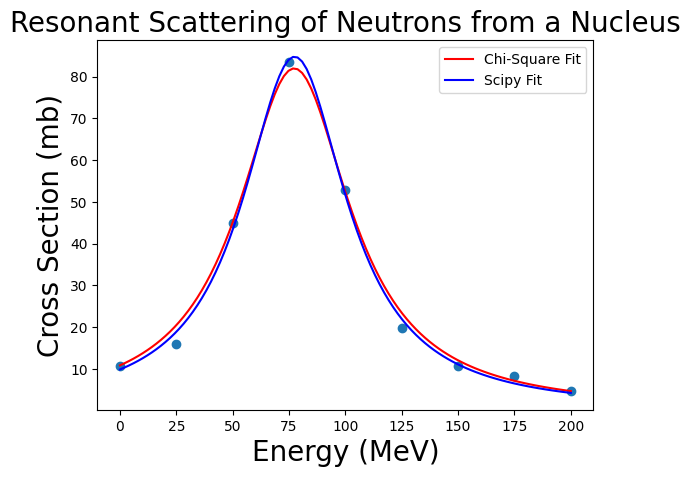

In [8]:
# and now let's plot: 
import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np

fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

x = np.linspace(0,200,100)
y = fit1(x)
z = fit2(x)

ax.scatter(ins,outs)
ax.plot(x,y,color = "red", label = "Chi-Square Fit")
ax.plot(x,z,color = "blue", label = "Scipy Fit")

# set the labels and titles:
ax.set_xlabel('Energy (MeV)', fontsize=20) # set the x label
ax.set_ylabel('Cross Section (mb)', fontsize=20) # set the y label
ax.set_title('Resonant Scattering of Neutrons from a Nucleus', fontsize=20) # set the title 

# construct the legend:
ax.legend(loc='upper right')  # Add a legend

plt.show() # show the plot here